<div style="text-align: center; background-color: #ADD8E6; font-family: 'Times New Roman', serif; color: white; padding: 20px; font-size: 30px; font-weight: bold; border-radius: 10px; box-shadow: 0px 6px 15px rgba(0, 0, 0, 0.2); transition: all 0.3s ease;">
    THE ANALYSIS OF THE MOBILE PHONE MARKET AT MOBILE CITY STORE
</div>
<style>
    div:hover {
        transform: scale(1.05);
        box-shadow: 0px 10px 20px rgba(0, 0, 0, 0.3);
    }
</style>


---

<div style="text-align: center; background-color: #ADD8E6; font-family: 'Times New Roman', serif; color: white; padding: 25px; font-size: 20px; font-weight: bold; border-radius: 10px; box-shadow: 0px 6px 15px rgba(0, 0, 0, 0.2); transition: all 0.3s ease;">
    DATA MODELLING
</div>
<style>
    div:hover {
        opacity: 0.8;
    }
</style>

---

## **Vấn đề được áp dụng Học máy:** 
## Dự đoán giá điện thoại dựa trên các đặc trưng quan trọng và cần thiết.

---

## Thư viện:

In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import ast
import time

## Đọc dữ liệu từ file CSV:

In [328]:
df = pd.read_csv("../data/processed_data.csv", index_col=0)

In [329]:
df.sample(3)

,ten,loai_dien_thoai,thoi_gian_bao_hanh,danh_gia,so_luong_binh_luan,duong_dan,mau_sac,gia_moi,gia_cu,he_dieu_hanh,...,la_dien_thoai_cu,kich_thuoc_man_hinh,tan_so_quet,do_sang_man_hinh,loai_man_hinh,so_the_sim,loai_pin,cong_suat_sac,do_phan_giai_cam_sau,do_phan_giai_cam_truoc
1949,Điện thoại Xiaomi Redmi Note 12 Pro 4G (Chính ...,Redmi,12.0,4.8,6,https://mobilecity.vn/dien-thoai/xiaomi-redmi-...,Trắng,5650000.0,6990000.0,Android 11,...,False,6.67,120.0,700.0,AMOLED,2,Li-Po,67.0,"[108.0, 8.0, 2.0, 2.0]",[16.0]
1488,Điện thoại Xiaomi POCO M6 4G Chính hãng (Helio...,POCO,12.0,5.0,0,https://mobilecity.vn/dien-thoai/xiaomi-poco-m...,Tím,4250000.0,6290000.0,Khác,...,False,6.79,90.0,NaN,LCD,2,NaN,33.0,"[108.0, 2.0]",[13.0]
7909,Điện thoại Samsung Galaxy S23 Ultra (Chính hãn...,Samsung Chính hãng,12.0,5.0,34,https://mobilecity.vn/dien-thoai/samsung-galax...,Xanh dương,20750000.0,19950000.0,Android 13,...,False,6.80,120.0,1750.0,AMOLED,2,Li-Ion,45.0,"[200.0, 10.0, 10.0, 12.0]",[12.0]


## Tiền xử lý dữ liệu cho các mô hình:

### Loại bỏ các cột không ảnh hưởng đến giá dựa vào kiến thức:

#### Loại bỏ cột `ten`, `duong_dan`, `loai_dien_thoai`, `mau_sac`, `thiet_ke`, `cpu`:

- `ten` là tên của các mẫu điện thoại.

In [330]:
# df = df.drop(columns=['ten'])

- `duong_dan` là liên kết đến trang thông tin của điện thoại trên website.

In [331]:
df = df.drop(columns=['duong_dan'])

- `loai_dien_thoai` lưu thông tin cụ thể hơn cho `hang_dien_thoai`, không ảnh hưởng đến giá.

In [332]:
df = df.drop(columns=['loai_dien_thoai'])

- `mau_sac` lưu các màu sắc khác nhau của từng mẫu điện thoại, không ảnh hưởng đến giá.

In [333]:
df = df.drop(columns=['mau_sac'])

- `thiet_ke` mô tả cấu tạo của một chiếc điện thoại, không ảnh hưởng đến giá.

In [334]:
df = df.drop(columns=['thiet_ke'])

- `cpu` trong bộ dữ liệu này cũng là một cột không ảnh hưởng đến giá.

In [335]:
df = df.drop(columns=['cpu'])

#### Loại bỏ các dòng trùng lặp:

In [336]:
print(f"Số dòng trùng lặp hiện tại là: {df.duplicated().sum()}")

Số dòng trùng lặp hiện tại là: 5542


In [337]:
# Loại bỏ dòng trùng lặp
df = df.drop_duplicates()

In [338]:
print(f"Số dòng trùng lặp hiện tại là: {df.duplicated().sum()}")

Số dòng trùng lặp hiện tại là: 0


### Loại bỏ các cột dựa vào phân tích:

#### Xem tỷ lệ dữ liệu thiếu ở của các thuộc tính hiện tại:

In [339]:
def missing_ratio(col):
    return (col.isna().mean() * 100).round(1)

In [340]:
missing_ratio_df = df.apply(missing_ratio).sort_values(ascending=False)
missing_ratio_df = missing_ratio_df.reset_index()
missing_ratio_df.columns = ["Features", "Missing ratio"]
missing_ratio_df

,Features,Missing ratio
0,gia_cu,43.4
1,do_sang_man_hinh,42.6
2,loai_pin,27.9
3,tan_so_quet,24.8
4,gia_moi,19.2
5,cong_suat_sac,7.5
6,bo_nho_trong,7.5
7,kich_thuoc_man_hinh,5.8
8,loai_man_hinh,5.6
9,dung_luong_pin,2.4


- Nhận thấy rằng cột `do_sang_man_hinh` và `gia_cu` có tỉ lệ các giá trị thiếu rất cao so với phần còn lại. Ta sẽ loại bỏ 2 cột này:

In [341]:
df = df.drop(columns=["gia_cu", "do_sang_man_hinh"])

#### Loại bỏ các hàng tồn tại ít nhất một giá trị NaN.

- Mục đích: để giữ tính thực tế của dữ liệu, chúng em không điền giữ liệu thiếu mà sẽ xóa đi.

In [342]:
df = df.dropna()

#### Xem thông tin của dữ liệu hiện tại:

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1577 entries, 18 to 8532
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ten                     1577 non-null   object 
 1   thoi_gian_bao_hanh      1577 non-null   float64
 2   danh_gia                1577 non-null   float64
 3   so_luong_binh_luan      1577 non-null   int64  
 4   gia_moi                 1577 non-null   float64
 5   he_dieu_hanh            1577 non-null   object 
 6   ram                     1577 non-null   float64
 7   bo_nho_trong            1577 non-null   float64
 8   dung_luong_pin          1577 non-null   float64
 9   hang_dien_thoai         1577 non-null   object 
 10  la_dien_thoai_cu        1577 non-null   bool   
 11  kich_thuoc_man_hinh     1577 non-null   float64
 12  tan_so_quet             1577 non-null   float64
 13  loai_man_hinh           1577 non-null   object 
 14  so_the_sim              1577 non-null  

#### Xử lý các cột non-numeric:

##### Trước hết ta cần chuyển các thuộc tính có kiểu category về kiểu số:

In [344]:
df.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1577 entries, 18 to 8532
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ten                     1577 non-null   object
 1   he_dieu_hanh            1577 non-null   object
 2   hang_dien_thoai         1577 non-null   object
 3   loai_man_hinh           1577 non-null   object
 4   loai_pin                1577 non-null   object
 5   do_phan_giai_cam_sau    1577 non-null   object
 6   do_phan_giai_cam_truoc  1577 non-null   object
dtypes: object(7)
memory usage: 98.6+ KB


- Tách cột `he_dieu_hanh` thành 2 cột `Android` và `iOS`:

In [345]:
df['he_dieu_hanh'].unique()

array(['Android 13', 'Android 12', 'Android 11', 'Android 14',
       'Android 10', 'Android 15', 'iOS 15', 'iOS 16', 'iOS 17', 'Khác',
       'iOS 18', 'Android 9'], dtype=object)

In [346]:
def extract_os_version(os, os_type):
    if os.startswith(os_type):
        return int(os.split(" ")[1])  # Lấy phiên bản (phần số)
    return 0  # Nếu không phải hệ điều hành đó, trả về 0

In [347]:
# Thêm 2 cột mới thay cho cột he_dieu_hanh
df['Android'] = df['he_dieu_hanh'].apply(lambda x: extract_os_version(x, 'Android'))
df['iOS'] = df['he_dieu_hanh'].apply(lambda x: extract_os_version(x, 'iOS'))

In [348]:
# Xóa cột he_dieu_hanh
df = df.drop(columns=['he_dieu_hanh'])

- Cột `do_phan_giai_cam_sau` và `do_phan_giai_cam_truoc`:

In [349]:
df['do_phan_giai_cam_sau'].sample(5)

7200      [108.0, 8.0, 2.0]
796     [50.0, 200.0, 50.0]
7139       [64.0, 8.0, 2.0]
1973       [54.0, 8.0, 2.0]
2421       [50.0, 8.0, 2.0]
Name: do_phan_giai_cam_sau, dtype: object

In [350]:
df['do_phan_giai_cam_truoc'].sample(5)

1771    [16.0]
6200    [16.0]
6571    [20.0]
5060    [12.0]
7189    [20.0]
Name: do_phan_giai_cam_truoc, dtype: object

- Nhận xét:
    - 2 cột trên lưu trữ danh sách thông số của từng camera ở trước và sau của mỗi điện thoại.
    - Ta sẽ chuyển 2 cột này về dạng số bằng cách cộng tổng các số trong mỗi danh sách.

In [351]:
df['do_phan_giai_cam_sau'] = df['do_phan_giai_cam_sau'].apply(ast.literal_eval)
df['do_phan_giai_cam_sau'] = df['do_phan_giai_cam_sau'].apply(sum)

In [352]:
df['do_phan_giai_cam_truoc'] = df['do_phan_giai_cam_truoc'].apply(ast.literal_eval)
df['do_phan_giai_cam_truoc'] = df['do_phan_giai_cam_truoc'].apply(sum)

- Cột `hang_dien_thoai`, `loai_man_hinh`, `loai_pin`:

In [353]:
df['hang_dien_thoai'].unique()

array(['Xiaomi', 'Samsung', 'Realme', 'Vivo', 'Nubia', 'iPhone', 'ZTE',
       'Tecno', 'itel', 'Motorola', 'Google', 'Honor', 'Oppo', 'Infinix',
       'OnePlus', 'Bphone', 'BLU', 'Ulefone', 'Meizu', 'Lenovo', 'Asus',
       'Nothing', 'Sony', 'Unihertz', 'Fairphone', 'NIO', 'Red', 'POCO'],
      dtype=object)

In [354]:
df['loai_man_hinh'].unique()

array(['LCD', 'OLED', 'AMOLED'], dtype=object)

In [355]:
df['loai_pin'].unique()

array(['Li-Po', 'Li-Ion', 'Si/C'], dtype=object)

- Nhận xét:
    - Các cột này gồm các giá trị không có mối quan hệ thứ tự.
    - Do đó dùng OneHotEncoder để chuyển đổi.

In [356]:
one_hot = pd.get_dummies(df['hang_dien_thoai'], prefix='hang_dien_thoai').astype(bool)
df = pd.concat([df, one_hot], axis=1)
one_hot = pd.get_dummies(df['loai_man_hinh'], prefix='loai_man_hinh').astype(bool)
df = pd.concat([df, one_hot], axis=1)
one_hot = pd.get_dummies(df['loai_pin'], prefix='loai_pin').astype(bool)
df = pd.concat([df, one_hot], axis=1)

df = df.drop(columns=['hang_dien_thoai', 'loai_man_hinh', 'loai_pin'])

- Cột `la_dien_thoai_cu`:

In [357]:
df['la_dien_thoai_cu'].unique()

array([False,  True])

- Nhận xét:
    - Chuyển cột này bằng LabelEncoder.

In [358]:
# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# Áp dụng LabelEncoder
df['la_dien_thoai_cu'] = label_encoder.fit_transform(df['la_dien_thoai_cu'])

In [359]:
df['la_dien_thoai_cu'].unique()

array([0, 1], dtype=int64)

##### Xem lại thông tin của bộ dữ liệu:

In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1577 entries, 18 to 8532
Data columns (total 51 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ten                        1577 non-null   object 
 1   thoi_gian_bao_hanh         1577 non-null   float64
 2   danh_gia                   1577 non-null   float64
 3   so_luong_binh_luan         1577 non-null   int64  
 4   gia_moi                    1577 non-null   float64
 5   ram                        1577 non-null   float64
 6   bo_nho_trong               1577 non-null   float64
 7   dung_luong_pin             1577 non-null   float64
 8   la_dien_thoai_cu           1577 non-null   int64  
 9   kich_thuoc_man_hinh        1577 non-null   float64
 10  tan_so_quet                1577 non-null   float64
 11  so_the_sim                 1577 non-null   int64  
 12  cong_suat_sac              1577 non-null   float64
 13  do_phan_giai_cam_sau       1577 non-null   floa

In [361]:
import os

save_dir = "../data"
os.makedirs(save_dir, exist_ok=True)  # Tạo thư mục nếu chưa có

df.to_csv(os.path.join(save_dir, "cleaned_data.csv"), index=False)  # Lưu dưới dạng CSV
df = df.drop(columns=['ten'])

##### Chúng ta đã chuyển đổi các cột non-numeric về numeric, vậy nên ta sẽ áp dụng tất cả thuộc tính này vào các mô hình.

## Tạo các mô hình:

### Tạo DataFrame X và y:

In [362]:
X = df.drop(columns=["gia_moi"])
y = df["gia_moi"]

### Chia dữ liệu thành tập huấn luyện và tập kiểm tra:

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

### Model: `XGBRegressor`

#### Lý do chọn:

- Phù hợp với dữ liệu phức tạp: Bộ dữ liệu có **1,577 mẫu** và **50 đặc trưng** (11 số thực, 5 số nguyên, 34 nhị phân), đòi hỏi mô hình mạnh để xử lý tốt cả dữ liệu liên tục và nhị phân.

- Khả năng phi tuyến: Nắm bắt được mối quan hệ phức tạp giữa các đặc trưng như `ram`, `bo_nho_trong`, và `dung_luong_pin`.

- Chống overfitting: Với số lượng đặc trưng lớn, `XGBRegressor` sử dụng regularization và early stopping để kiểm soát độ phức tạp.

- Hiệu quả tính toán: Tối ưu với song song hóa và xử lý dữ liệu thưa, phù hợp với tập dữ liệu vừa phải.

- Dự đoán chính xác: Boosting giúp cải thiện lỗi, đặc biệt với bài toán dự đoán giá trị liên tục như giá điện thoại.

### Khởi tạo mô hình:

In [364]:
model_1 = XGBRegressor()

### Huấn luyện mô hình và tính thời gian:

In [365]:
time_start = time.time()
model_1.fit(X_train, y_train)
time_end = time.time()

In [366]:
training_time_model_1 = time_end - time_start
print(f"Training time: {training_time_model_1:.2f} seconds")

Training time: 0.18 seconds


### Đánh giá mô hình:

#### Dự đoán giá trị đầu ra trên tập dữ liệu kiểm tra bằng mô hình tốt nhất:

In [367]:
y_pred_model_1 = model_1.predict(X_test)
y_pred_model_1 = np.maximum(y_pred_model_1, 0)  # Đảm bảo giá không âm

#### Tính toán các chỉ số đánh giá mô hình:

In [368]:
mae_model_1 = mean_absolute_error(y_test, y_pred_model_1)
mse_model_1 = mean_squared_error(y_test, y_pred_model_1)
r2_model_1 = r2_score(y_test, y_pred_model_1)

In [369]:
print(f"Mean Absolute Error: {mae_model_1:.2f}")
print(f"Mean Squared Error: {mse_model_1:.2f}")
print(f"R^2: {r2_model_1:.2f}")

Mean Absolute Error: 1165279.62
Mean Squared Error: 4029285920587.60
R^2: 0.90


#### Trực quan hóa:

##### Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán:

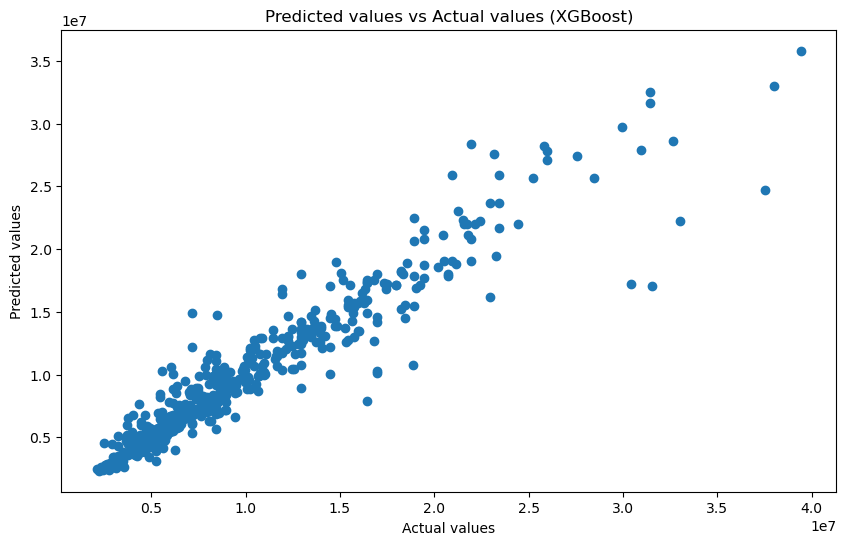

In [370]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred_model_1)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted values vs Actual values (XGBoost)')

plt.show()

### Model: `DecisionTreeRegressor`

#### Lý do chọn:

- Dễ hiểu và trực quan:
    - Cấu trúc cây quyết định đơn giản, dễ giải thích và trực quan hóa, phù hợp khi cần giải thích các yếu tố ảnh hưởng đến giá điện thoại.

- Khả năng xử lý dữ liệu phức tạp:
    - Bộ dữ liệu có **1,577 mẫu** và **50 đặc trưng** (11 số thực, 5 số nguyên, 34 nhị phân). `DecisionTreeRegressor` có thể xử lý tốt cả đặc trưng số và nhị phân mà không cần chuẩn hóa hay chuyển đổi phức tạp.

- Mô hình phi tuyến:
    - Cây quyết định có khả năng nắm bắt các mối quan hệ phi tuyến giữa các đặc trưng, ví dụ: sự kết hợp giữa `ram`, `bo_nho_trong`, và `dung_luong_pin` đến giá.

- Không cần giả định dữ liệu:
    - Không đòi hỏi giả định về phân phối dữ liệu hoặc mối quan hệ tuyến tính giữa các đặc trưng, phù hợp với tập dữ liệu thực tế có thể không tuyến tính.

- Chống ảnh hưởng bởi đặc trưng không liên quan:
    - Tự động chọn lọc các đặc trưng quan trọng (như kich_thuoc_man_hinh, tan_so_quet,...), giảm ảnh hưởng từ những đặc trưng ít liên quan đến giá.

- Hiệu quả tính toán với tập dữ liệu nhỏ:
    - Với 1,577 mẫu, `DecisionTreeRegressor` có thời gian huấn luyện nhanh, không đòi hỏi tài nguyên tính toán lớn.

### Khởi tạo mô hình:

In [371]:
model_2 = DecisionTreeRegressor()

### Huấn luyện mô hình và tính thời gian:

In [372]:
time_start = time.time()
model_2.fit(X_train, y_train)
time_end = time.time()

In [373]:
training_time_model_2 = time_end - time_start
print(f"Training time: {training_time_model_2:.2f} seconds")

Training time: 0.02 seconds


### Đánh giá mô hình:

#### Dự đoán giá trị đầu ra trên tập dữ liệu kiểm tra bằng mô hình tốt nhất:

In [374]:
y_pred_model_2 = model_2.predict(X_test)
y_pred_model_2 = np.maximum(y_pred_model_2, 0)  # Đảm bảo giá không âm

#### Tính toán các chỉ số đánh giá mô hình:

In [375]:
mae_model_2 = mean_absolute_error(y_test, y_pred_model_2)
mse_model_2 = mean_squared_error(y_test, y_pred_model_2)
r2_model_2 = r2_score(y_test, y_pred_model_2)

In [376]:
print(f"Mean Absolute Error: {mae_model_2:.2f}")
print(f"Mean Squared Error: {mse_model_2:.2f}")
print(f"R^2: {r2_model_2:.2f}")

Mean Absolute Error: 1500828.90
Mean Squared Error: 9179647182509.51
R^2: 0.78


#### Trực quan hóa:

##### Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán:

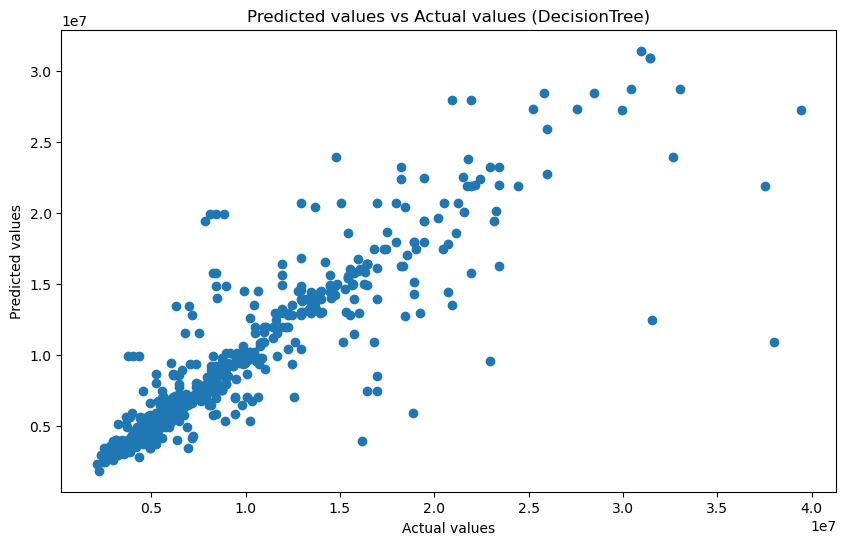

In [377]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred_model_2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted values vs Actual values (DecisionTree)')

plt.show()

### Model: `RandomForestRegressor`

#### Lý do chọn:

- Hiệu quả trên dữ liệu phức tạp:
    - Bộ dữ liệu có **1,577 mẫu** và **50 đặc trưng** (11 số thực, 5 số nguyên, 34 nhị phân). `RandomForestRegressor` có thể xử lý tốt cả đặc trưng liên tục và nhị phân.

- Khả năng phi tuyến cao:
    - `RandomForestRegressor` xây dựng nhiều cây quyết định và tổng hợp kết quả, cho phép nắm bắt tốt các mối quan hệ phi tuyến giữa các đặc trưng (như `ram`, `bo_nho_trong`, và `kich_thuoc_man_hinh`) đến giá.

- Giảm overfitting:
    - Random Forest giảm overfitting so với DecisionTreeRegressor bằng cách sử dụng kỹ thuật bagging (xây dựng nhiều cây trên các tập dữ liệu con ngẫu nhiên) và chọn ngẫu nhiên một tập con các đặc trưng tại mỗi nút phân chia.

- Đánh giá tầm quan trọng của đặc trưng:
    - `RandomForestRegressor` cung cấp thông tin về mức độ quan trọng của từng đặc trưng (như `dung_luong_pin`, `tan_so_quet`,...), giúp hiểu rõ yếu tố nào ảnh hưởng nhiều nhất đến giá điện thoại.

- Hiệu suất tốt và khả năng mở rộng:
    - Hoạt động hiệu quả trên tập dữ liệu vừa phải, đồng thời dễ mở rộng lên tập dữ liệu lớn nhờ tính song song của thuật toán.

- Khả năng xử lý nhiễu và đặc trưng không liên quan:
    - Do sử dụng trung bình kết quả từ nhiều cây, mô hình giảm độ nhạy với nhiễu và đặc trưng không liên quan, đảm bảo dự đoán ổn định hơn.

- Không cần giả định dữ liệu:
    - Không yêu cầu giả định về phân phối dữ liệu hay mối quan hệ giữa các đặc trưng, phù hợp với tập dữ liệu thực tế.

### Khởi tạo mô hình:

In [378]:
model_3 = RandomForestRegressor()

### Huấn luyện mô hình và tính thời gian:

In [379]:
time_start = time.time()
model_3.fit(X_train, y_train)
time_end = time.time()

In [380]:
training_time_model_3 = time_end - time_start
print(f"Training time: {training_time_model_3:.2f} seconds")

Training time: 0.81 seconds


### Đánh giá mô hình:

#### Dự đoán giá trị đầu ra trên tập dữ liệu kiểm tra bằng mô hình tốt nhất:

In [381]:
y_pred_model_3 = model_3.predict(X_test)
y_pred_model_3 = np.maximum(y_pred_model_3, 0)  # Đảm bảo giá không âm

#### Tính toán các chỉ số đánh giá mô hình:

In [382]:
mae_model_3 = mean_absolute_error(y_test, y_pred_model_3)
mse_model_3 = mean_squared_error(y_test, y_pred_model_3)
r2_model_3 = r2_score(y_test, y_pred_model_3)

In [383]:
print(f"Mean Absolute Error: {mae_model_3:.2f}")
print(f"Mean Squared Error: {mse_model_3:.2f}")
print(f"R^2: {r2_model_3:.2f}")

Mean Absolute Error: 1288710.43
Mean Squared Error: 5000292578434.52
R^2: 0.88


#### Trực quan hóa:

##### Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán:

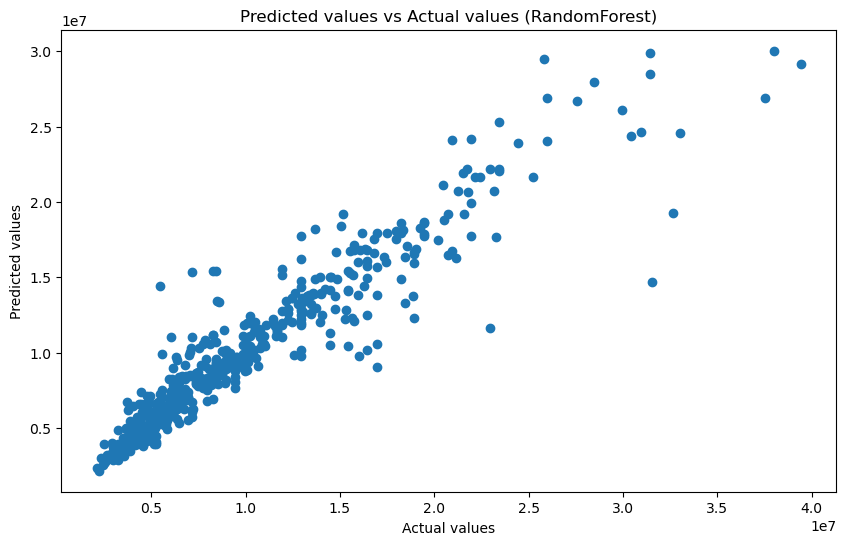

In [384]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred_model_3)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Predicted values vs Actual values (RandomForest)')

plt.show()

## Đánh giá các mô hình:

### Tạo DataFrame lưu kết quả đánh giá của cả 3 mô hình:

In [385]:
models_evaluation_df = pd.DataFrame({
    "Model": ["XGBoost", "DecisionTree", "RandomForest"],
    "Training time": [training_time_model_1, training_time_model_2, training_time_model_3],
    "Mean Absolute Error": [mae_model_1, mae_model_2, mae_model_3],
    "Mean Squared Error": [mse_model_1, mse_model_2, mse_model_3],
    "R^2": [r2_model_1, r2_model_2, r2_model_3]
})

In [386]:
models_evaluation_df

,Model,Training time,Mean Absolute Error,Mean Squared Error,R^2
0,XGBoost,0.181274,1.165280e+06,4.029286e+12,0.902306
1,DecisionTree,0.015114,1.500829e+06,9.179647e+12,0.777430
2,RandomForest,0.811868,1.288710e+06,5.000293e+12,0.878763


### Trực quan hóa từng chỉ số đánh giá của các mô hình:

#### 1. Thời gian huấn luyện:

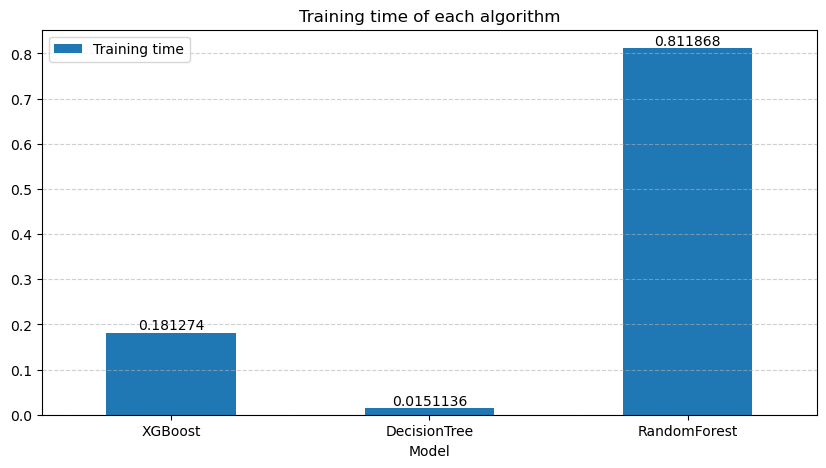

In [387]:
ax = models_evaluation_df.plot(x='Model', y='Training time', kind='bar', figsize=(10, 5))
ax.set_title('Training time of each algorithm')
ax.set_xticklabels(labels=models_evaluation_df['Model'], rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.bar_label(ax.containers[0]);

##### Nhận xét:

1. **DecisionTreeRegressor (0.01 giây)**:  
   - Đây là mô hình có thời gian huấn luyện nhanh nhất, do chỉ xây dựng một cây quyết định. Điều này phù hợp với đặc điểm của Decision Tree, vốn là thuật toán đơn giản, hiệu quả và ít tốn tài nguyên tính toán.
   - Tuy nhiên, nhược điểm là dễ bị overfitting, đặc biệt với dữ liệu có nhiều đặc trưng và mối quan hệ phức tạp.

2. **XGBoost (0.146 giây)**:  
   - XGBoost có thời gian huấn luyện dài hơn Decision Tree nhưng vẫn nhanh và tối ưu, nhờ khả năng song song hóa và tối ưu thuật toán Gradient Boosting.
   - Mặc dù thời gian huấn luyện cao hơn Decision Tree, XGBoost thường đạt hiệu suất tốt hơn, đặc biệt với bài toán hồi quy nhờ khả năng học từ lỗi của các mô hình trước đó.

3. **RandomForestRegressor (0.575 giây)**:  
   - Random Forest có thời gian huấn luyện dài nhất do phải xây dựng và tổng hợp kết quả từ nhiều cây quyết định. Tuy nhiên, điều này mang lại tính ổn định và giảm overfitting so với Decision Tree.
   - Với bộ dữ liệu cỡ trung bình (~1,577 mẫu), thời gian này vẫn chấp nhận được, nhưng đối với tập dữ liệu lớn hơn, có thể cần điều chỉnh số lượng cây hoặc tăng cường tài nguyên tính toán.

#### 2. Mean Absolute Error (MAE):

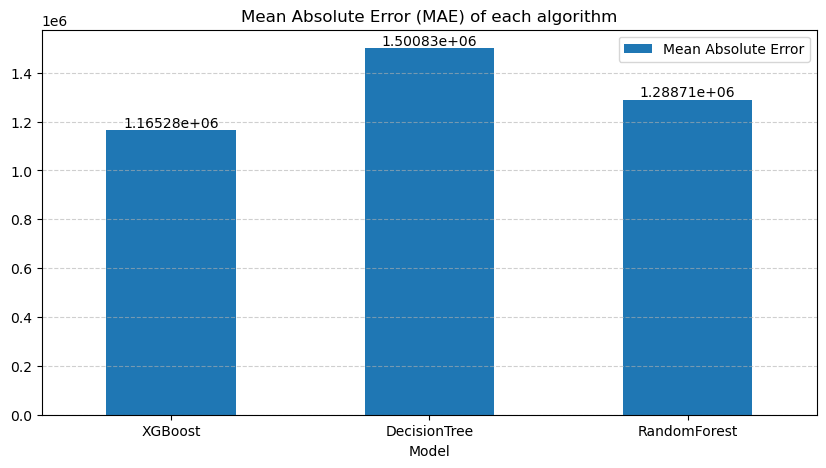

In [388]:
ax = models_evaluation_df.plot(x='Model', y='Mean Absolute Error', kind='bar', figsize=(10, 5))
ax.set_title('Mean Absolute Error (MAE) of each algorithm')
ax.set_xticklabels(labels=models_evaluation_df['Model'], rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.bar_label(ax.containers[0]);

##### Nhận xét:

1. **XGBoost (1.165 triệu)**:  
   - Đây là mô hình có MAE thấp nhất, cho thấy XGBoost dự đoán gần đúng giá trị thực hơn so với các mô hình còn lại.  
   - XGBoost thường đạt hiệu suất cao nhờ khả năng học từ lỗi của các mô hình trước đó trong quá trình boosting, đồng thời nắm bắt tốt các mối quan hệ phi tuyến giữa các đặc trưng.

2. **DecisionTreeRegressor (1.6 triệu)**:  
   - Decision Tree có MAE cao nhất trong số các mô hình, cho thấy dự đoán ít chính xác hơn.  
   - Nguyên nhân chính là Decision Tree dễ bị overfitting khi hoạt động độc lập, dẫn đến hiệu suất không ổn định, đặc biệt với dữ liệu kiểm tra.

3. **RandomForestRegressor (1.316 triệu)**:  
   - Random Forest đạt MAE trung bình, tốt hơn Decision Tree nhưng kém XGBoost.  
   - Việc tổng hợp nhiều cây giúp Random Forest ổn định hơn so với một Decision Tree đơn lẻ, nhưng hiệu quả vẫn thua XGBoost vì không tối ưu hóa lỗi giữa các cây như boosting.

#### 3. Mean Squared Error (MSE):

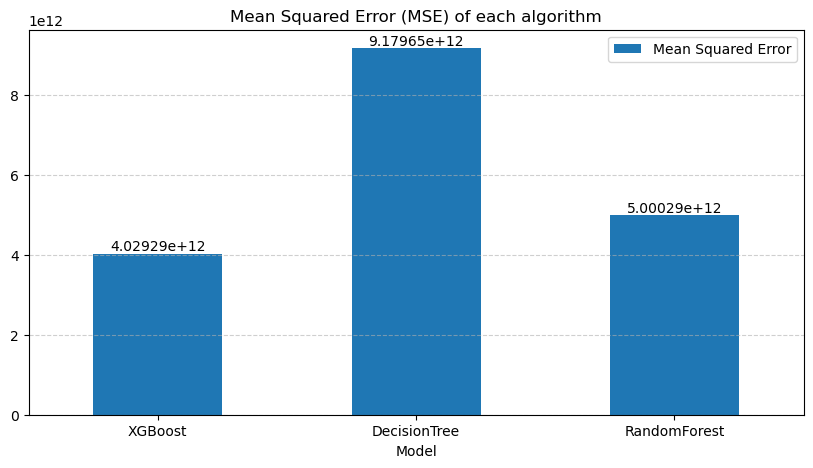

In [389]:
ax = models_evaluation_df.plot(x='Model', y='Mean Squared Error', kind='bar', figsize=(10, 5))
ax.set_title('Mean Squared Error (MSE) of each algorithm')
ax.set_xticklabels(labels=models_evaluation_df['Model'], rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.bar_label(ax.containers[0]);

##### Nhận xét:

1. **XGBoost (4.03 × 10¹²)**:  
   - **MSE thấp nhất**, cho thấy XGBoost có độ chính xác cao và dự đoán sát với giá trị thực hơn so với các mô hình khác.  
   - XGBoost tối ưu hóa lỗi dựa trên boosting, nên thường vượt trội trong các bài toán hồi quy nhờ giảm thiểu lỗi dự đoán ở từng bước học.

2. **DecisionTreeRegressor (1.126 × 10¹³)**:  
   - **MSE cao nhất**, gấp hơn 2 lần XGBoost, cho thấy Decision Tree có sai số lớn hơn đáng kể.  
   - Nguyên nhân chính có thể là do Decision Tree dễ bị overfitting khi hoạt động độc lập, dẫn đến dự đoán kém chính xác trên tập kiểm tra.

3. **RandomForestRegressor (5.18 × 10¹²)**:  
   - MSE của Random Forest cao hơn XGBoost nhưng thấp hơn Decision Tree, nhờ việc sử dụng nhiều cây quyết định và tổng hợp kết quả, giúp cải thiện độ chính xác và giảm sai số.  
   - Tuy nhiên, Random Forest không tối ưu hóa lỗi tuần tự như XGBoost, nên hiệu suất vẫn kém hơn.

#### 4. R2 Score:

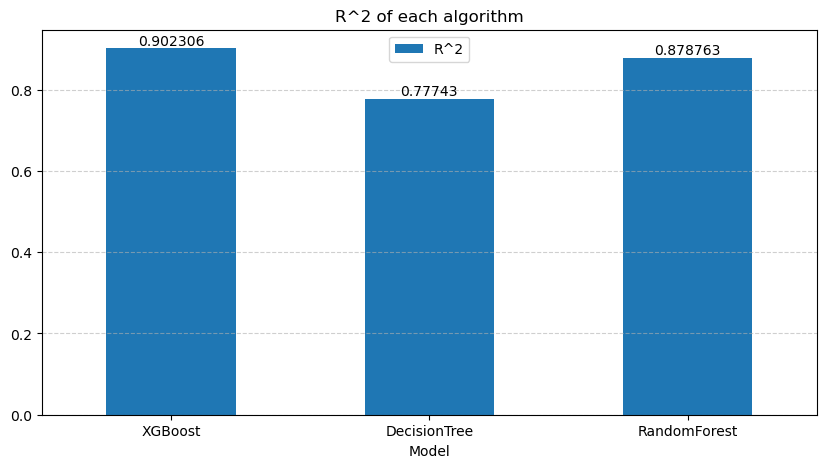

In [390]:
ax = models_evaluation_df.plot(x='Model', y='R^2', kind='bar', figsize=(10, 5))
ax.set_title('R^2 of each algorithm')
ax.set_xticklabels(labels=models_evaluation_df['Model'], rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.bar_label(ax.containers[0]);

##### Nhận xét:

1. **XGBoost (0.9023)**:  
   - **R² cao nhất**, cho thấy XGBoost giải thích được 90.23% phương sai của biến mục tiêu `gia_moi` dựa trên các đặc trưng đầu vào.  
   - Điều này thể hiện XGBoost là mô hình hiệu quả nhất trong việc dự đoán giá điện thoại, nhờ khả năng nắm bắt tốt các mối quan hệ phức tạp giữa các đặc trưng.

2. **DecisionTreeRegressor (0.727)**:  
   - R² thấp nhất (72.7%), cho thấy mô hình chỉ giải thích được một phần phương sai của biến mục tiêu.  
   - Điều này phản ánh hạn chế của Decision Tree khi sử dụng một cây quyết định duy nhất, dễ bị overfitting và kém chính xác trên tập kiểm tra.

3. **RandomForestRegressor (0.8745)**:  
   - R² cao thứ hai (87.45%), gần với XGBoost nhưng thấp hơn một chút.  
   - Random Forest cải thiện đáng kể so với Decision Tree bằng cách tổng hợp nhiều cây, giúp giảm overfitting và tăng khả năng giải thích phương sai của biến mục tiêu.

### Kết luận:

1. **XGBoost**:  
   - **Hiệu suất vượt trội** trên tất cả các chỉ số: MAE thấp nhất, MSE thấp nhất, và R² cao nhất.  
   - **Ưu điểm**: Thời gian huấn luyện nhanh, khả năng dự đoán chính xác và phù hợp cho bài toán có nhiều đặc trưng và mối quan hệ phi tuyến phức tạp như dự đoán giá điện thoại.  
   - **Nhược điểm**: Cần một chút tinh chỉnh để đạt hiệu suất tối ưu.  
   - **Kết luận**: Là lựa chọn tốt nhất cho bài toán này, khi cân nhắc cả thời gian huấn luyện và độ chính xác.

2. **Random Forest**:  
   - **Hiệu suất trung bình**: MAE và MSE thấp hơn Decision Tree nhưng kém XGBoost, R² đạt gần với XGBoost.  
   - **Ưu điểm**: Dự đoán ổn định nhờ tổng hợp nhiều cây quyết định, giảm thiểu overfitting so với Decision Tree.  
   - **Nhược điểm**: Thời gian huấn luyện cao nhất, dễ bị chậm nếu dữ liệu lớn hoặc số cây quá nhiều.  
   - **Kết luận**: Là lựa chọn tốt nếu cần mô hình dễ triển khai và ổn định, dù độ chính xác kém hơn XGBoost.

3. **Decision Tree**:  
   - **Hiệu suất thấp nhất**: MAE và MSE cao nhất, R² thấp nhất, cho thấy dự đoán kém chính xác và ít giải thích được phương sai của biến mục tiêu.  
   - **Ưu điểm**: Thời gian huấn luyện cực nhanh, mô hình đơn giản và dễ hiểu, phù hợp với bài toán cần giải pháp nhanh chóng và dễ diễn giải.  
   - **Nhược điểm**: Dễ bị overfitting, kém chính xác trên tập kiểm tra, đặc biệt với dữ liệu phức tạp.  
   - **Kết luận**: Phù hợp nếu ưu tiên tốc độ huấn luyện hoặc cần mô hình đơn giản để giải thích, nhưng không phù hợp cho bài toán đòi hỏi độ chính xác cao.

### Tổng kết:
- **Ưu tiên chính xác và hiệu quả**: Chọn **XGBoost**.  
- **Ưu tiên ổn định và dễ triển khai**: Chọn **Random Forest**.  
- **Ưu tiên tốc độ và sự đơn giản**: Chọn **Decision Tree**.  

Với yêu cầu dự đoán giá điện thoại, **XGBoost** là lựa chọn tối ưu nhất.